## Optimizers

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import pdb
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# load data from torchvision module
train_set = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

test_set = datasets.MNIST(
    root= './data',
    train= False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

 97%|█████████████████████████████████████████████████████████████████▎ | 9658368/9912422 [00:11<00:00, 2366133.89it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                        | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 94930.30it/s]                                                                                          

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz



0it [00:00, ?it/s]
 99%|███████████████████████████████████████████████████████████████████▏| 1630208/1648877 [00:04<00:00, 396145.14it/s]
1654784it [00:04, 344777.70it/s]                                                                                       

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                         | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 30696.76it/s]                                                                                           

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 256)


In [5]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 6, kernel_size= 5, stride= 1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels= 12, kernel_size=5, stride = 1)
        
        self.fc1= nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features= 60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
         # first hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size= 2, stride= 2)
        
        # second hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size= 2, stride= 2)
        
        # first linear layer 
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        #second linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        #output layer
        t = self.out(t)
        #ideally here we would use softmax function but since we are going to use cross entropy loss, softmax
        # is not explicitly required 
        
        return F.log_softmax(t)

### Vanilla SGD

In [6]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()
lr = 0.01
#weights = [(child.weight.data, child.bias.data) for child in net.children()]

for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        
        for child in net.children():
            child.weight.data -= lr * child.weight.grad.data
            child.bias.data -= lr * child.bias.grad.data
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            child.weight.grad.data.zero_()
            child.bias.grad.data.zero_()

epoch 0


C:\Users\Tushara\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
9920512it [00:30, 2366133.89it/s]                                                                                      

epoch 1
epoch 2


In [7]:
sgd_losses_ = [(l.data.item()) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses_]

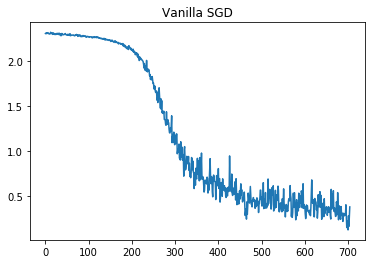

In [8]:
plt.plot(sgd_losses_)
title = plt.title("Vanilla SGD")

### SGD with Momentum

In [9]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001
gamma = 0.9
weight_v_prev = [0 for i in range(5)]
bias_v_prev = [0 for i in range(5)]


for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(weight_v_prev)):
            
            #print("Gradients\n" ,children[i].weight.grad.data)
            weight_v_new = gamma * weight_v_prev[i] + lr * children[i].weight.grad.data
            bias_v_new = gamma * bias_v_prev[i] + lr * children[i].bias.grad.data
            
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            children[i].weight.data -= weight_v_new
            children[i].bias.data -= bias_v_new
            
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0


C:\Users\Tushara\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1
epoch 2


In [10]:
sgdmom_losses_ = [(l.data.numpy()) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

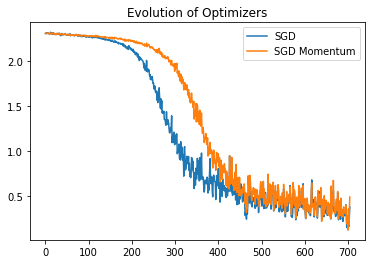

In [11]:
plt.plot(sgd_losses_)
plt.plot(sgdmom_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum'))

### Nesterov

In [15]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001
gamma = 0.9
weight_v_prev = [0 for i in range(5)]
bias_v_prev = [0 for i in range(5)]


for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        
        for i in range(len(weight_v_prev)):
            
            #update WEIGHT
            # take a step ahead in momentum direction
            original_weight = children[i].weight.data
            children[i].weight.data -= gamma * weight_v_prev[i]
            
            #calculate loss and gradients 
            future_outputs = net(images)
            future_loss = criterion(future_outputs, labels)
            future_loss.backward(retain_graph = True)
            future_grad = children[i].weight.grad.data
            
            weight_v_new = gamma * weight_v_prev[i] + lr * future_grad
            weight_v_prev[i] = weight_v_new
            
            children[i].weight.data = original_weight
            children[i].weight.data -= weight_v_new
            
            #zero the gradients so that gradients dont get accumulate
            net.zero_grad()
            #children[i].weight.grad.data.zero_()
            
            
            #update BIAS
            original_bias = children[i].bias.data
            children[i].bias.data -= gamma * bias_v_prev[i]
            
            #calculate loss and gradients 
            future_outputs = net(images)
            future_loss = criterion(future_outputs, labels)
            future_loss.backward(retain_graph = True)
            future_grad = children[i].bias.grad.data
            
            bias_v_new = gamma * bias_v_prev[i] + lr * future_grad
            bias_v_prev[i] = bias_v_new
            
            children[i].bias.data = original_bias
            children[i].bias.data -= bias_v_new
            
            #zero the gradients so that gradients dont get accumulate
            net.zero_grad()
            

epoch 0


C:\Users\Tushara\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1
epoch 2


In [17]:
nesterov_losses_ = [(l.data.numpy()) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]

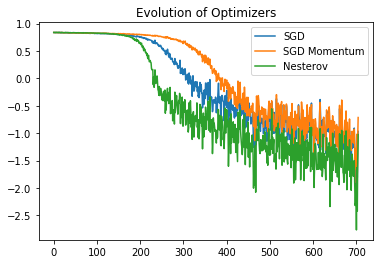

In [18]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov'))

### Adagrad

In [27]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.01

children = list(net.children())
cache = [[torch.zeros(children[index].weight.shape), torch.zeros(children[index].bias.shape)] for index in range(len(children))]
epsilon = 1e-8

for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        #print("New batch {} \n\n".format(idx))
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(cache)):
            
            #update weights
            children[i].weight.data -= lr * (children[i].weight.grad.data / torch.sqrt(cache[i][0].data ) + epsilon)
            children[i].bias.data -= lr * (children[i].bias.grad.data / torch.sqrt(cache[i][1].data) + epsilon)
            
            #update cache
            cache[i][0].data += children[i].weight.grad.data * children[i].weight.grad.data
            cache[i][1].data += children[i].bias.grad.data * children[i].bias.grad.data
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0


C:\Users\Tushara\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1
epoch 2


In [51]:
child.weight.grad.new

<function Tensor.new>

In [30]:
adagrad_losses_ = [(l.data.numpy()) for l in losses]
adagrad_log_losses_ = [np.log(l) for l in adagrad_losses_]

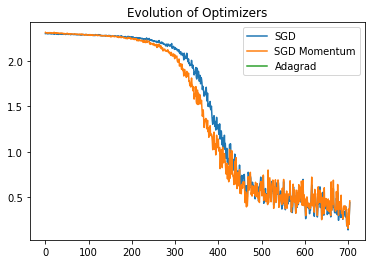

In [31]:
plt.plot(sgd_losses_)
plt.plot(sgdmom_losses_)
#plt.plot(nesterov_losses_)
plt.plot(adagrad_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Adagrad'))

### RMSprop

In [ ]:
##train
net = Network()
net.to(device)

epochs = 2 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.01

children = list(net.children())
cache = [[torch.zeros(children[index].weight.shape), torch.zeros(children[index].bias.shape)] for index in range(len(children))]
epsilon = 1e-8

for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(cache)):
            
            #update weights
            children[i].weight.data -= lr * (children[i].weight.grad.data / torch.sqrt(cache[i][0] + epsilon))
            children[i].bias.data -= lr * (children[i].bias.grad.data / torch.sqrt(cache[i][1] + epsilon))
            
            #update cache
            cache[i][0] += children[i].weight.grad.data * children[i].weight.grad.data
            cache[i][1] += children[i].bias.grad.data * children[i].bias.grad.data
            
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            if epoch is not 1:
                children[i].weight.grad.data.zero_()
                children[i].bias.grad.data.zero_()

In [ ]:
1e-3

In [40]:
rand = torch.tensor([[1,0,0],[0,1,0], [0,0,0]])
rand

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 0]])

In [46]:
rand.coalesce()

RuntimeError: coalesce is not implemented for type CPUType